In [1]:
!pip install torch
!pip install torchvision
!pip install timm

import os
import sys
from glob import glob
import numpy as np
import pandas as pd
import cv2
from PIL import Image
from tqdm.notebook import tqdm
from time import time
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing as mp

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data

from torchvision import transforms, models
from torchvision.transforms import Resize, ToTensor, Normalize
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
import re
import csv
import timm

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device: [%s]"%device)

device: [cuda:0]


In [3]:
train_dir = '/opt/ml/input/data/train'
df = pd.read_csv(os.path.join(train_dir, 'train.csv'))
image_dir = os.path.join(train_dir, 'images')

In [5]:
mean = (0.548, 0.504, 0.479)
std = (0.237, 0.247, 0.246)

In [ ]:
# Random seed 설정
SEED = 2021
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)  # type: ignore
torch.backends.cudnn.deterministic = True  # type: ignore
torch.backends.cudnn.benchmark = True  # type: ignore


# Labeling

In [6]:
# 잘못된 정보를 수정한 새로운 csv파일 생성, path는 그대로

def get_fixed_labeled_csv(): 
    df = pd.read_csv(f"{train_data_path}/train.csv")

    id_overlap_error = ["003397"]
    gender_labeling_error = ['006359', '006360', '006361', '006362', '006363', '006364']
    mask_labeling_error = ['000020', '004418', '005227']

    id_max = int(max(df['id']))
    id_new = id_max+1

    new_data_list=[]

    for idx in tqdm(range(len(df))):  # tqdm 을 이용하면 현재 데이터가 얼마나 처리되고 있는지 파악되어 좋습니다.
        _path = df['path'].iloc[idx]  # 순서대로 가져와야 하기 때문에 iloc을 사용해 가져옵니다.
        _gender = df['gender'].iloc[idx]
        _age = df['age'].iloc[idx]
        _id = df['id'].iloc[idx]

        if _id in id_overlap_error:
            _id='%06d'%(id_new)
            id_new += 1
        
        if _id in gender_labeling_error:
            if _gender == "male":
                _gender = 'female'
            else:
                _gender = 'male'
        
        for img_name in Path(f"{train_image_path}/{_path}").iterdir():  # 각 dir의 이미지들을 iterative 하게 가져옵니다.
            img_stem = img_name.stem  # 해당 파일의 파일명만을 가져옵니다. 확장자 제외.
            if not img_stem.startswith('._'):  # avoid hidden files
                if _id in mask_labeling_error:
                    if img_stem == "incorrect_mask":
                        img_stem = 'normal'
                    elif img_stem == 'normal':
                        img_stem = 'incorrect_mask'
                new_data_list.append([_id, _age, _gender, img_stem, img_name.__str__()]) 
        
    df = pd.DataFrame(new_data_list)
    df.columns = ['id', 'age', 'gender', 'stem', 'img_path']
    
    df['label'] = 0  # SET SCORE
    # AGE
    df['label'] += ((df['age'] >= 30) & (df['age'] < 60))*1
    df['label'] += (df['age'] >= 60)*2

    # GENDER
    df['label'] += (df['gender'] == 'female')*3

    # MASK wearing condition
    df['label'] += (df['stem'].isin(['incorrect_mask']))*6
    df['label'] += (df['stem'].isin(['normal']))*12

    df.to_csv('./labeled_data.csv', sep=',' ,na_rep='NaN')

한 사람의 7개 이미지에 대해 라벨링한 결과를 리턴

라벨링한 결과를 csv에 저장

In [8]:
labels_normal = pd.read_csv("labeled_data.csv")['stem' == 'normal'].label
labels_incorrect = pd.read_csv("labeled_data.csv")['stem' == 'incorrect'].label
labels_masked = pd.read_csv("labeled_data.csv")['stem' != 'normal' or 'stem' != 'incorrect'].label

image_path_normal = pd.read_csv("labeled_data.csv")['stem' == 'normal'].img_path
image_path_incorrect = pd.read_csv("labeled_data.csv")['stem' == 'incorrect'].img_path
image_path_masked = pd.read_csv("labeled_data.csv")['stem' != 'normal' or 'stem' != 'incorrect'].img_path

In [9]:
lst=list(zip(labels,image_path))

success


### 2.1.2 Albumentation Style Augmentation Function
- Albumentation은 numpy 형식으로 이미지를 받아 데이터를 변형시킵니다.
- opencv 기반으로 빠르고, 다양한 Augmentation 방법이 제공되는 점에서 장점이 있습니다.

In [10]:
from albumentations import *
from albumentations.pytorch import ToTensorV2


def get_transforms(need=('train1','train2','train3','train4','train5', 'val'), img_size=(512, 384), mean=(0.548, 0.504, 0.479), std=(0.237, 0.247, 0.246)):
    """
    train 혹은 validation의 augmentation 함수를 정의합니다. train은 데이터에 많은 변형을 주어야하지만, validation에는 최소한의 전처리만 주어져야합니다.
    
    Args:
        need: 'train', 혹은 'val' 혹은 둘 다에 대한 augmentation 함수를 얻을 건지에 대한 옵션입니다.
        img_size: Augmentation 이후 얻을 이미지 사이즈입니다.
        mean: 이미지를 Normalize할 때 사용될 RGB 평균값입니다.
        std: 이미지를 Normalize할 때 사용될 RGB 표준편차입니다.

    Returns:
        transformations: Augmentation 함수들이 저장된 dictionary 입니다. transformations['train']은 train 데이터에 대한 augmentation 함수가 있습니다.
    """
    transformations = {}
    if 'train1' in need:
        transformations['train'] = Compose([
            Resize(img_size[0], img_size[1], p=1.0),
            HorizontalFlip(p=1),
            Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)

    if 'train2' in need:
        transformations['train'] = Compose([
            Resize(img_size[0], img_size[1], p=1.0),
            RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=1),
            Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)
    
    if 'train3' in need:
        transformations['train'] = Compose([
            Resize(img_size[0], img_size[1], p=1.0),
            GaussNoise(p=0.1),
            Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)

    if 'val' in need:
        transformations['val'] = Compose([
            Resize(img_size[0], img_size[1]),
            Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)
    return transformations

# Train Dataset

In [11]:
class MaskBaseDataset(data.Dataset):
    num_classes = 3 * 2 * 3

    def __init__(self,image_path,labels,transform=None):
        self.image_path = image_path
        self.labels = labels
        self.transform = transform
        

    def set_transform(self, transform):
        """
        transform 함수를 설정하는 함수입니다.
        """
        self.transform = transform
        

    def __getitem__(self, index):
        """
        데이터를 불러오는 함수입니다. 
        데이터셋 class에 데이터 정보가 저장되어 있고, index를 통해 해당 위치에 있는 데이터 정보를 불러옵니다.
        
        Args:
            index: 불러올 데이터의 인덱스값입니다.
        """
        # 이미지를 불러옵니다.
        image = Image.open(image_path[index])
        
        # 이미지를 Augmentation 시킵니다.
        image_transform = self.transform(image=np.array(image))['image']
        return image_transform, self.label[index]

    def __len__(self):
        return len(self.image_path)

In [12]:
# 정의한 Augmentation 함수와 Dataset 클래스 객체를 생성합니다.
transform = get_transforms(mean=mean, std=std)

dataset_normal = MaskBaseDataset(image_path_normal,labels_normal, transform)
dataset_incorrect = MaskBaseDataset(image_path_incorrect,labels_incorrect, transform)
dataset_masked = MaskBaseDataset(image_path_masked,labels_masked, transform)

# train dataset과 validation dataset을 8:2 비율로 나눕니다.
n_val = int(len(dataset_normal) * 0.2)
n_train = len(dataset_normal) - n_val
train_dataset_normal, val_dataset_normal = data.random_split(dataset_normal, [n_train, n_val])

n_val = int(len(dataset_incorrect) * 0.2)
n_train = len(dataset_incorrect) - n_val
train_dataset_incorrect, val_dataset_incorrect = data.random_split(dataset_incorrect, [n_train, n_val])


n_val = int(len(dataset_masked) * 0.2)
n_train = len(dataset_masked) - n_val
train_dataset_masked, val_dataset_masked = data.random_split(dataset_masked, [n_train, n_val])

train_dataset_normal_1=train_dataset_normal
train_dataset_normal_2=train_dataset_normal
train_dataset_normal_3=train_dataset_normal

train_dataset_incorrect_1=train_dataset_incorrect
train_dataset_incorrect_2=train_dataset_incorrect
train_dataset_incorrect_3=train_dataset_incorrect

val_dataset = val_dataset_normal + val_dataset_incorrect + train_dataset_masked, val_dataset_masked

# 각 dataset에 augmentation 함수를 설정합니다.
train_dataset_normal_1.dataset.set_transform(transform['train1'])
train_dataset_normal_2.dataset.set_transform(transform['train2'])
train_dataset_normal_3.dataset.set_transform(transform['train3'])

train_dataset_incorrect_1.dataset.set_transform(transform['train1'])
train_dataset_incorrect_2.dataset.set_transform(transform['train2'])
train_dataset_incorrect_3.dataset.set_transform(transform['train3'])

val_dataset.dataset.set_transform(transform['val'])

train_dataset = train_dataset_normal_1 
train_dataset += train_dataset_normal_2 
train_dataset += train_dataset_normal_3
train_dataset += train_dataset_incorrect_1
train_dataset += train_dataset_incorrect_2
train_dataset += train_dataset_incorrect_3

image_datasets={'train':train_dataset, 'validation':val_dataset}

# DataLoader
- 정의한 Dataset을 바탕으로 DataLoader을 생성합니다.
- Dataset은 이미지 한장을 주는 모듈이라면, DataLoader은 여러 이미지를 batch_size만큼 묶어 전달해줍니다.

In [13]:
# training dataloader은 데이터를 섞어주어야 합니다. (shuffle=True)
dataloaders = {
    'train':
    data.DataLoader(image_datasets['train'],
                    batch_size=12,
                    shuffle=True,
                    num_workers=4),  # for Kaggle
    'validation':
    data.DataLoader(image_datasets['validation'],
                    batch_size=12,
                    shuffle=False,
                    num_workers=4)  # for Kaggle
}

In [14]:
images, labels = next(iter(dataloaders['train']))
print(f'images shape: {images.shape}')
print(f'labels shape: {labels.shape}')

images shape: torch.Size([12, 3, 512, 384])
labels shape: torch.Size([12])


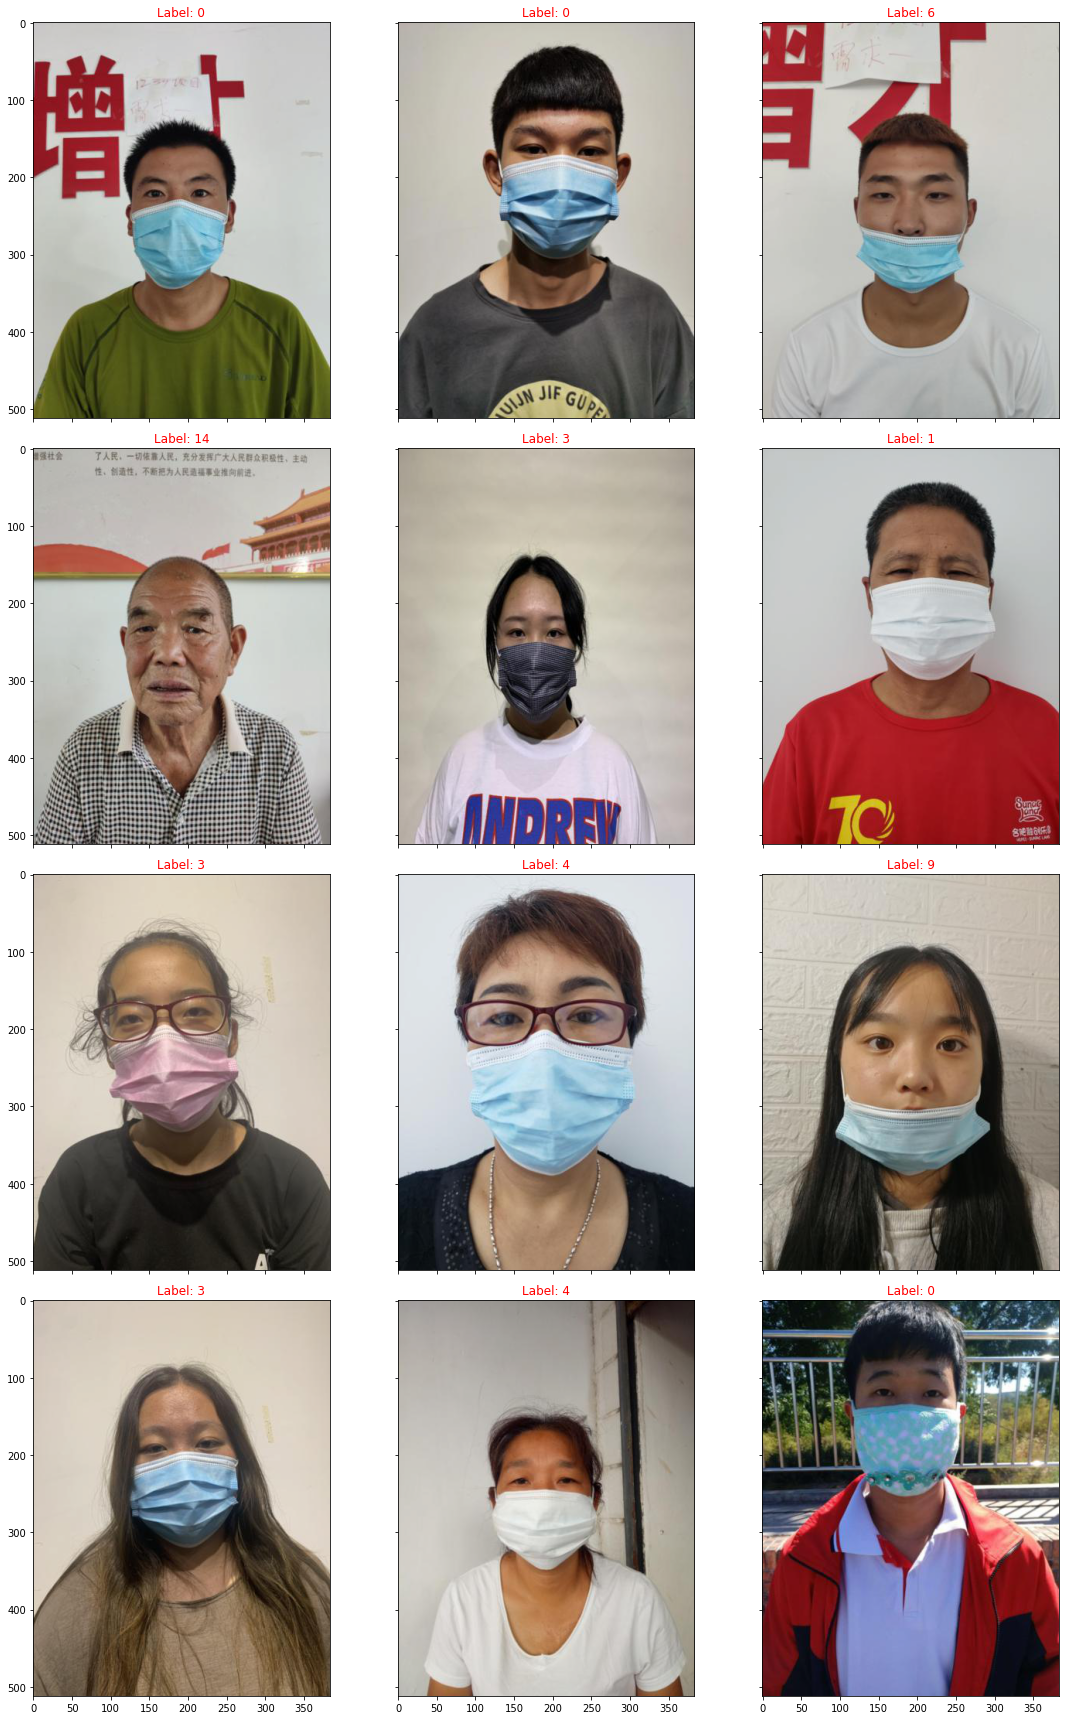

In [15]:
from torchvision import transforms

# Augmentation으로 이미지를 Normalize했기 때문에, 역으로 다시 Normalize 해주어야합니다.
inv_normalize = transforms.Normalize(
    mean=[-m / s for m, s in zip(mean, std)],
    std=[1 / s for s in std]
)

n_rows, n_cols = 4, 3

fig, axes = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(16, 24))
for i in range(n_rows*n_cols):
    axes[i%n_rows][i//(n_cols+1)].imshow(inv_normalize(images[i]).permute(1, 2, 0))
    axes[i%n_rows][i//(n_cols+1)].set_title(f'Label: {labels[i]}', color='r')
plt.tight_layout()

# Model 정의

In [16]:
model = timm.create_model('tf_efficientnet_l2_ns', pretrained = True)
    
for param in model.parameters():
    param.requires_grad = False   
    
model.classifier = nn.Linear(in_features=5504, out_features = 18, bias = True)

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

In [18]:
def train_model(model, criterion, optimizer, num_epochs=5):
    for epoch in tqdm(range(num_epochs)):
        epoch_f1 = 0
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return model

In [19]:
model_trained = train_model(model, criterion, optimizer, num_epochs=30)

Epoch 1/30
----------
train loss: 1.2395, acc: 0.6075
validation loss: 0.7552, acc: 0.7381
Epoch 2/30
----------
train loss: 0.7620, acc: 0.7341
validation loss: 0.8430, acc: 0.7466
Epoch 3/30
----------
train loss: 0.7072, acc: 0.7544
validation loss: 0.5221, acc: 0.8193
Epoch 4/30
----------
train loss: 0.6335, acc: 0.7741
validation loss: 0.4822, acc: 0.8291
Epoch 5/30
----------
train loss: 0.6088, acc: 0.7862
validation loss: 0.4193, acc: 0.8556
Epoch 6/30
----------
train loss: 0.5785, acc: 0.7912
validation loss: 0.4595, acc: 0.8442
Epoch 7/30
----------
train loss: 0.5588, acc: 0.7961
validation loss: 0.4097, acc: 0.8672
Epoch 8/30
----------
train loss: 0.5388, acc: 0.8069
validation loss: 0.4869, acc: 0.8323
Epoch 9/30
----------
train loss: 0.5287, acc: 0.8092
validation loss: 0.4102, acc: 0.8569
Epoch 10/30
----------
train loss: 0.5228, acc: 0.8120
validation loss: 0.3841, acc: 0.8720
Epoch 11/30
----------
train loss: 0.4978, acc: 0.8220
validation loss: 0.4096, acc: 0.86

## Save and load the model

In [20]:
!mkdir models
!mkdir models/pytorch

mkdir: cannot create directory 'models': File exists
mkdir: cannot create directory 'models/pytorch': File exists


In [21]:
torch.save(model_trained, 'models/pytorch/weights.h5')

In [22]:
# model = models.resnet50(pretrained=False).to(device)
# model.fc = nn.Sequential(
#                nn.Linear(2048, 128),
#                nn.ReLU(inplace=True),
#                nn.Linear(128, 18)).to(device)
# model = torch.load('models/pytorch/weights.h5')

## 3. Inference

In [24]:
# # meta 데이터와 이미지 경로를 불러옵니다.
test_dir = '/opt/ml/input/data/eval'
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
test_image_dir = os.path.join(test_dir, 'images')

# # Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
test_image_paths = [os.path.join(test_image_dir, img_id) for img_id in submission.ImageID]

In [25]:
def get_test_transforms(img_size=(512, 384), mean=(0.548, 0.504, 0.479), std=(0.237, 0.247, 0.246)):
    transformations = Compose([
                Resize(img_size[0], img_size[1]),
                Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
                ToTensorV2(p=1.0),
            ], p=1.0)
    return transformations

In [26]:
test_transform = get_test_transforms(mean=mean, std=std)

test_dataset = TestDataset(test_image_paths, test_transform)

test_loader = data.DataLoader(
    test_dataset,
    shuffle=False
)

In [27]:
# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
model = torch.load('models/pytorch/weights.h5')
model.eval()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in tqdm(test_loader):
    with torch.no_grad():
        images = images.to(device)
        pred = model(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir, 'submission.csv'), index=False)
print('test inference is done!')


test inference is done!
